# Load Data

In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv1D,Conv2D,BatchNormalization,MaxPooling1D,MaxPooling2D,Reshape,LSTM,TimeDistributed,Input,Lambda, concatenate
from keras.utils import to_categorical
from keras import layers, regularizers
import matplotlib.pyplot as plt
import os


In [2]:
data_folder = './EEG-Data'
os.chdir(data_folder)
print(os.getcwd())

c:\Users\tiffh\ECE-C147\Deep-Learning-EEG-BCI-Signal-Processing\EEG-Data


(2115, 22, 1000)


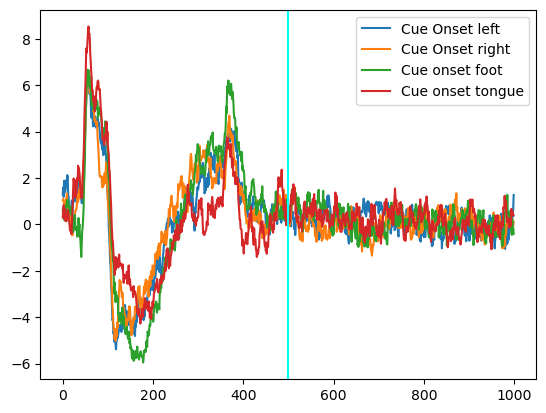

In [3]:
## Loading and visualizing the data

## Loading the dataset


X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])






In [4]:
def train_data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    return total_X,total_y


def test_data_prep(X):
    
    total_X = None
    
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)
    
    
    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)
    
    return total_X

## Preprocessing the dataset

# X_train_valid_prep,y_train_valid_prep = train_data_prep(X_train_valid,y_train_valid,2,2,True)
X_test_prep = test_data_prep(X_test) 

## Random splitting and reshaping the data

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(2115, 250, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]
x_valid_prep = test_data_prep(x_valid)
x_train, y_train = train_data_prep(x_train, y_train, 2,2,True)
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid_prep.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid_prep.reshape(x_valid_prep.shape[0], x_valid_prep.shape[1], x_valid_prep.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)
Shape of X after trimming: (250, 22, 800)
Shape of X after maxpooling: (250, 22, 400)
Shape of X after trimming: (1865, 22, 800)
Shape of X after maxpooling: (1865, 22, 400)
Shape of X after averaging+noise and concatenating: (3730, 22, 400)
Shape of X after subsampling and concatenating: (7460, 22, 400)
Shape of Y: (7460,)
Shape of training set: (7460, 22, 400)
Shape of validation set: (250, 22, 400)
Shape of training labels: (7460,)
Shape of validation labels: (250,)
Shape of training labels after categorical conversion: (7460, 4)
Shape of validation labels after categorical conversion: (250, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (7460, 22, 400, 1)
Shape of validation set after adding width info: (250, 22, 400, 1)
Shape of test set after adding width info: (443, 22, 400, 1)
Shape of training set after dimension reshaping: (7460,

# Hybrid Model Architecture

In [16]:
def hybrid_model(units, input_dim):
 # Building the model using sequential class
    hybrid_cnn_lstm_model = Sequential()

    for filter, num_filter in zip([10 for _ in range(4)], [25, 50, 100, 200]):
        hybrid_cnn_lstm_model.add(Conv2D(filters=num_filter, kernel_size=(filter,1), padding='same', activation='elu', input_shape=(400,1,22)))
        hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
        hybrid_cnn_lstm_model.add(BatchNormalization())
        hybrid_cnn_lstm_model.add(Dropout(0.6))


    # FC+LSTM layers
    hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
    hybrid_cnn_lstm_model.add(Dense((input_dim))) # FC layer with 100 units
    hybrid_cnn_lstm_model.add(Reshape((input_dim,1))) # Reshape my output of FC layer so that it's compatible
    hybrid_cnn_lstm_model.add(LSTM(units, dropout=0.4, recurrent_dropout=0.1, input_shape=(input_dim,1), return_sequences=False))


    # Output layer with Softmax activation 
    hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

    # keras.utils.plot_model(hybrid_cnn_lstm_model, to_file='./Gallery/hybrid_cnn_model_plot.png', show_shapes=True, show_layer_names=True)

    return hybrid_cnn_lstm_model



# Train Hybrid Model

In [11]:
# Model parameters
learning_rate = 1e-3
epochs = 100
hybrid_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

In [12]:
from keras.callbacks import ReduceLROnPlateau

# results = []


hybrid_cnn_lstm_model = hybrid_model(10, 60)

# Compiling the model
hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
                optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8,
                            patience=5, min_lr=5e-5)

# Training and validating the model
hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(x_train,
            y_train,
            batch_size=64,
            epochs=epochs,
            validation_data=(x_valid, y_valid), 
            callbacks=[reduce_lr],
            verbose=True)


hybrid_score = hybrid_cnn_lstm_model.evaluate(x_test, y_test, verbose=0)
model_filename = f'../Models/CNN_LSTM_hybrid_{hybrid_score[1]}.h5'
hybrid_cnn_lstm_model.save(model_filename)



Epoch 1/100
117/117 [==============================] - 13s 82ms/step - loss: 1.3646 - accuracy: 0.3009 - val_loss: 1.3455 - val_accuracy: 0.3160 - lr: 0.0010
Epoch 2/100
117/117 [==============================] - 9s 77ms/step - loss: 1.3122 - accuracy: 0.3536 - val_loss: 1.2907 - val_accuracy: 0.3520 - lr: 0.0010
Epoch 3/100
117/117 [==============================] - 9s 77ms/step - loss: 1.2716 - accuracy: 0.4031 - val_loss: 1.2419 - val_accuracy: 0.4080 - lr: 0.0010
Epoch 4/100
117/117 [==============================] - 9s 77ms/step - loss: 1.2399 - accuracy: 0.4351 - val_loss: 1.1928 - val_accuracy: 0.4480 - lr: 0.0010
Epoch 5/100
117/117 [==============================] - 9s 77ms/step - loss: 1.2059 - accuracy: 0.4483 - val_loss: 1.2304 - val_accuracy: 0.4120 - lr: 0.0010
Epoch 6/100
117/117 [==============================] - 13s 111ms/step - loss: 1.1861 - accuracy: 0.4638 - val_loss: 1.1983 - val_accuracy: 0.4240 - lr: 0.0010
Epoch 7/100
117/117 [==============================] - 

c:\Users\tiffh\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


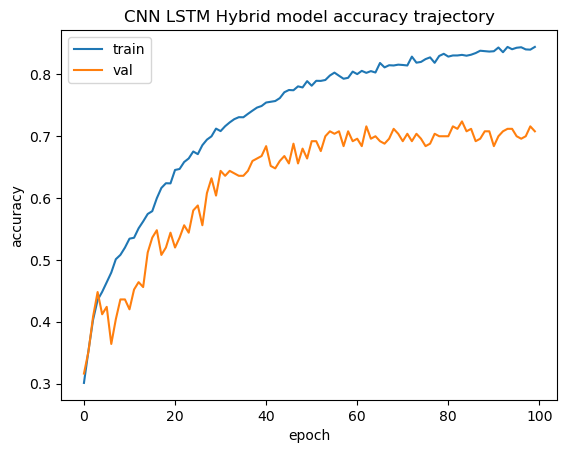

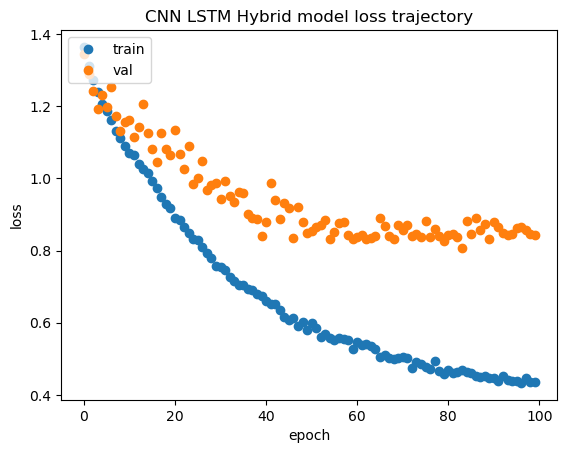

In [13]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['accuracy'])
plt.plot(hybrid_cnn_lstm_model_results.history['val_accuracy'])
plt.title('CNN LSTM Hybrid model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['loss'],'o')
plt.plot(hybrid_cnn_lstm_model_results.history['val_loss'],'o')
plt.title('CNN LSTM Hybrid model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [14]:
## Testing the basic RNN model

rnn_score = hybrid_cnn_lstm_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN LSTM model:',rnn_score[1])

Test accuracy of the hybrid CNN LSTM model: 0.7020316123962402


8/8 [==============================] - 0s 15ms/step


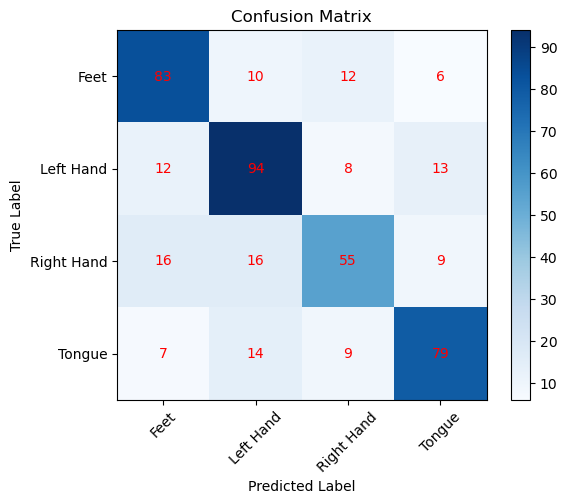

              precision    recall  f1-score   support

           0       0.70      0.75      0.72       111
           1       0.70      0.74      0.72       127
           2       0.65      0.57      0.61        96
           3       0.74      0.72      0.73       109

    accuracy                           0.70       443
   macro avg       0.70      0.70      0.70       443
weighted avg       0.70      0.70      0.70       443



In [15]:

from utils import confusion_matrix
# import keras

# import importlib
# importlib.reload(confusion_matrix)

model = hybrid_cnn_lstm_model #keras.models.load_model('../Models/CNN_LSTM_hybrid_testacc_units_inputdim/CNN_LSTM_hybrid_0.6884875893592834_30_60.h5')

y_test_pred = model.predict(x_test)
y_val_pred = model.predict(x_valid)

y_valid_categorical = np.argmax(y_valid, axis=1)
y_val_pred_categorical = np.argmax(y_val_pred, axis=1)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
# y_test_categorical = np.argmax(y_test, axis=1)

# List of class names (adjust as per your dataset)
class_names = ['Feet', 'Left Hand', 'Right Hand', 'Tongue']

# Plot confusion matrix
true_labels = np.argmax(y_test, axis=1)

## Testing 

confusion_matrix.plot_confusion_matrix(true_labels, y_test_pred_classes, class_names, False, '../Gallery/CNN_LSTM_confusion_matrix.png')

confusion_matrix.metrics_report(true_labels, y_test_pred_classes, False)